
#### Author: Barun Barua, Genevive chyrmang,Kangkana Bora, Manob jyoti saikia
#### Description: MobileViT-Unet+DICE architecture and training source code

In [ ]:
# all important modules to import

import os
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf

import numpy as  np
import segmentation_models as sm   # link to libary:https://segmentation-models.readthedocs.io/en/latest/index.html
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Activation, Add, Multiply, UpSampling2D, Lambda
from keras_cv_attention_models import mobilevit
from tensorflow.keras.models import Model


#### Data loading pipeline

In [2]:
class data_generator(tf.keras.utils.Sequence):
    def __init__(self, image_paths,mask_path, batch_size=32,shuffle=False, backbone='resnet18',image_size=(224,224),p_status=False):
        self.image_paths=image_paths
        self.mask_paths=mask_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.backbone=backbone
        self.preprocessing= sm.get_preprocessing(self.backbone)
        self.image_size=image_size
        self.p_status=p_status
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    def __getitem__(self,idx):
        start_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size
        img_batch=self.image_paths[start_idx:end_idx]
        mask_batch=self.mask_paths[start_idx:end_idx]
        X=[]
        Y=[]
        

        for i,value, in enumerate(img_batch):
             bgr_image=cv2.imread(img_batch[i])
             rgb_image=cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
             rgb_image=cv2.resize(rgb_image,self.image_size)
             mask=cv2.imread(mask_batch[i])
             mask=cv2.resize(mask,self.image_size)
             mask=cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
             #print(value)
             if self.p_status==True:
                 rgb_image=self.preprocessing(rgb_image)
             X.append(rgb_image/255)
             Y.append(mask/255.0)
        
        return np.array(X),np.expand_dims(np.array(Y),axis=3)
    def on_epoch_end(self):#dont use this 
        if self.shuffle==True:
            np.random.shuffle(self.image_paths)
            np.random.shuffle(self.mask_paths)
            

    def __iter__(self):
        # Initialize the iteration index
        self.current_idx = 0
        return self

    def __next__(self):
        if self.current_idx >= len(self):
            raise StopIteration
        else:
            batch = self.__getitem__(self.current_idx)
            self.current_idx += 1
            return batch
                

train_images_paths=np.load("../train_images.npy",allow_pickle=False)#Replace with your own dataset directory or numpy file
train_mask_paths=np.load("../train_mask.npy",allow_pickle=False)#Replace with your own dataset directory or numpy file
val_images_paths=np.load("../val_image.npy",allow_pickle=False)#Replace with your own dataset directory or numpy file
val_mask_paths=np.load("../val_mask.npy",allow_pickle=False)#Replace with your own dataset directory or numpy file


### Implementation of  MobileViT-Unet architecture 

In [3]:


def Mb_UNet(input_shape, num_classes):
   
    #ENCODER
    #-------------------------------------------------------------------------------
    # Will download and load pretrained imagenet weights.
    mm = mobilevit.MobileViT_S(input_shape=(224,224,3),pretrained="imagenet")
    # last feature layer of mobilevit
    x=mm.get_layer('features_swish').output 
    #skip connections
    skip_connections_names=['stem_conv','stack2_block1_deep_3_conv','stack3_block1_deep_3_conv','stack4_block1_deep_3_conv']
    Skip_connection_layers=[mm.get_layer(name).output for name in skip_connections_names]
    mm.trainable=True

  

    # DECODER
    #----------------------------------1st Block--------------------------------------------------------------------
  
    up6 = Conv2DTranspose(512//2, 2, strides=(2, 2), padding='same')(x)
    merge6 = concatenate([up6,Skip_connection_layers[3]], axis=3)
    conv6 = Conv2D(512//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    #---------------------------------------2nd block-----------------------------------------------------------------------
    up7 = Conv2DTranspose(256//2, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([up7,Skip_connection_layers[2]], axis=3)
  
    conv7 =Conv2D(256//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    #--------------------------------------3rd block--------------------------------------------------------------------------
    up8 = Conv2DTranspose(128//2, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([up8,Skip_connection_layers[1]], axis=3)

    conv8 = Conv2D(128//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    #------------------------------------------4th block-----------------------------------------------------------------
    up9 = Conv2DTranspose(64//2, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([up9,Skip_connection_layers[0]], axis=3)
    conv9 = Conv2D(64//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)

    #-------------------------------------------final block-----------------------------------------------------------
    
    up10 = Conv2DTranspose(64//2, 2, strides=(2, 2), padding='same')(conv9)
    conv10 = Conv2D(64//2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up10)
  
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv10)
   
    model = Model(inputs=mm.inputs, outputs=conv10)
    model.summary()
    
    return model

#### Training configurations

In [4]:

# Parameter for training 
BATCH_SIZE = 8
number_of_class=1
LR = 0.0001
EPOCHS = 40

Backbone='mobile_vit_only_unet_dice'

Loss=sm.losses.dice_loss
optm=tf.keras.optimizers.Adam(LR)

#calling of model
model = Mb_UNet((224,224,3),number_of_class)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optm,Loss, metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./'+Backbone+".h5", save_best_only=True, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
]




>>>> Load pretrained from: C:\Users\HP\.keras\models\mobilevit_s_imagenet.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 16  432         ['stem_pad[0][0]']               
                                )                                                                 
                 

#### Training Model 

In [5]:
# train model() (donot execute during evaluation)
train=data_generator(train_images_paths,train_mask_paths,BATCH_SIZE)
val=data_generator(val_images_paths,val_mask_paths,BATCH_SIZE,)
history = model.fit_generator(
    train, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val,
)

Epoch 1/40


C:\Users\HP\AppData\Local\Temp\ipykernel_21188\2859103505.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


258/258 [==============================] - 84s 270ms/step - loss: 0.2367 - iou_score: 0.6244 - f1-score: 0.7660 - val_loss: 0.2237 - val_iou_score: 0.6370 - val_f1-score: 0.7763
Epoch 2/40
258/258 [==============================] - 66s 257ms/step - loss: 0.2248 - iou_score: 0.6358 - f1-score: 0.7754 - val_loss: 0.2237 - val_iou_score: 0.6370 - val_f1-score: 0.7763
Epoch 3/40
258/258 [==============================] - 67s 258ms/step - loss: 0.2248 - iou_score: 0.6358 - f1-score: 0.7754 - val_loss: 0.2237 - val_iou_score: 0.6370 - val_f1-score: 0.7763
Epoch 4/40
258/258 [==============================] - 67s 261ms/step - loss: 0.2248 - iou_score: 0.6358 - f1-score: 0.7754 - val_loss: 0.2237 - val_iou_score: 0.6370 - val_f1-score: 0.7763
Epoch 5/40
258/258 [==============================] - 66s 256ms/step - loss: 0.2248 - iou_score: 0.6358 - f1-score: 0.7754 - val_loss: 0.2237 - val_iou_score: 0.6370 - val_f1-score: 0.7763
Epoch 6/40
258/258 [==============================] - 66s 257ms/st

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Evaluation of model on test set images

In [ ]:
from sklearn.metrics import precision_score, recall_score

def evaluate_pred(img_path,mask_path,key):
    precision=[]
    recall=[]
    for i,value in enumerate(img_path):
        bgr_image=cv2.imread(img_path[i])
        rgb_image=cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        rgb_image=cv2.resize(rgb_image,(224,224))
        mask=cv2.imread(mask_path[i])
        mask=cv2.resize(mask,(224,224))
        mask=cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
       
        mask=mask.astype(bool).astype(int)
        image=np.expand_dims(rgb_image/255,axis=0)
        
        prd_mask=model.predict(image,verbose=False)
        pr_mask=prd_mask.squeeze()
        threshold = 0.5
        pr_mask= pr_mask > threshold
        
        pr_mask=pr_mask.astype(np.uint8)
        precision.append(precision_score(mask.flatten(), pr_mask.flatten(),))
        recall.append(recall_score(mask.flatten(), pr_mask.flatten()))
    precision=np.mean(np.array(precision))
    recall=np.mean(np.array(recall))
    return precision,recall




key=["Adenocarcinoma","High-grade IN","Low-grade IN","Normal","Polyp","Serrated adenoma"]
model.load_weights('/mobile_vit_only_unet_dice.h5') #loading model weights
mean_iou=[]
mean_dice=[]
mean_p=[]
mean_r=[]
for i in key:

    test_images_paths=np.load(i+"_test_images.npy",allow_pickle=False)
    test_mask_paths=np.load(i+"_test_mask.npy",allow_pickle=False)
    test=data_generator(test_images_paths,test_mask_paths,8)
    scores = model.evaluate_generator(test)
    print("Loss: {:.5}".format(scores[0]))
    for metric, value in zip(metrics, scores[1:]):
        if metric.__name__=='iou_score':
            mean_iou.append(value)
        else:
            mean_dice.append(value)
        print("mean {} of {}: {:.5}".format(metric.__name__,i, value))

    p,r=evaluate_pred(test_images_paths,test_mask_paths,i)
    mean_p.append(p)
    mean_r.append(r)
b='MobileVit-Unet+Dice'        
dict={"Model":b,"type_of_images":key,"Iou":mean_iou,'Dice':mean_dice,'Precision':mean_p,'Recall':mean_r}

In [12]:
#saving the files in csv file
import pandas as pd
data=pd.DataFrame(dict)
data.to_csv('_analysis_on_test_set.csv')

{'Model': 'MobileVit-Unet+Dice', 'type_of_images': ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp', 'Serrated adenoma'], 'Iou': [0.8598160743713379, 0.9026826024055481, 0.9406010508537292, 0.9363548159599304, 0.9374754428863525, 0.9396358728408813], 'Dice': [0.924310028553009, 0.9487884640693665, 0.9693706035614014, 0.9671236872673035, 0.967710554599762, 0.9688724875450134], 'Precision': [0.9490044813768131, 0.9679384300455337, 0.9816601871038463, 0.9860252779926668, 0.9784476503299216, 0.981978552059091], 'Recall': [0.9011418404234485, 0.9240592100356956, 0.951611179936364, 0.9369470670601083, 0.9409777243529818, 0.9491810993086948]}
                 Model    type_of_images       Iou      Dice  Precision  \
0  MobileVit-Unet+Dice    Adenocarcinoma  0.859816  0.924310   0.949004   
1  MobileVit-Unet+Dice     High-grade IN  0.902683  0.948788   0.967938   
2  MobileVit-Unet+Dice      Low-grade IN  0.940601  0.969371   0.981660   
3  MobileVit-Unet+Dice            N

#### Visualization of generated masks

(1, 224, 224, 3)
1/1 [==============================] - 10s 10s/step


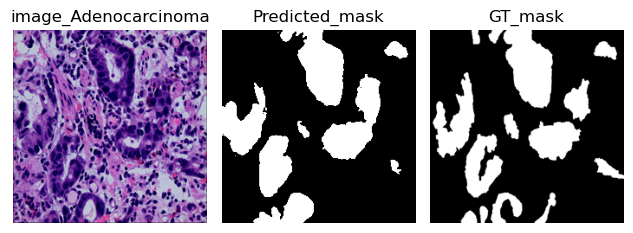

(1, 224, 224, 3)
1/1 [==============================] - 0s 62ms/step


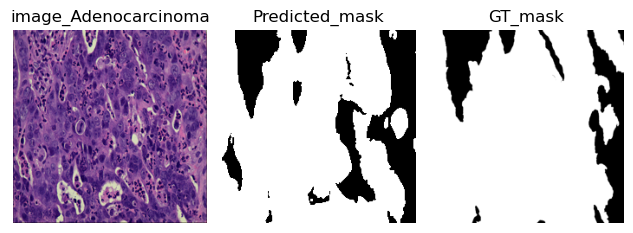

(1, 224, 224, 3)
1/1 [==============================] - 0s 50ms/step


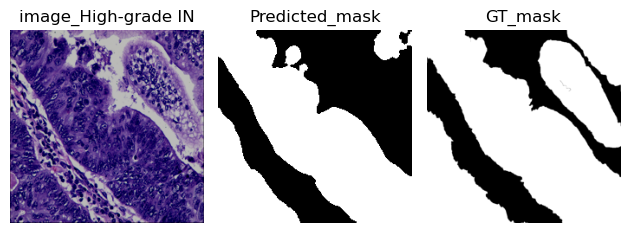

(1, 224, 224, 3)
1/1 [==============================] - 0s 51ms/step


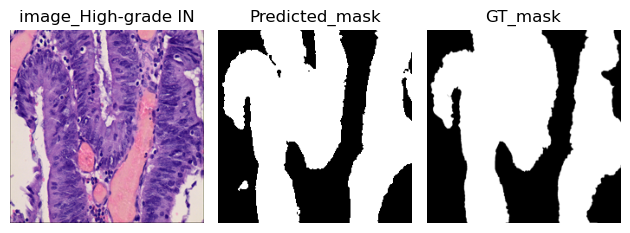

(1, 224, 224, 3)
1/1 [==============================] - 0s 50ms/step


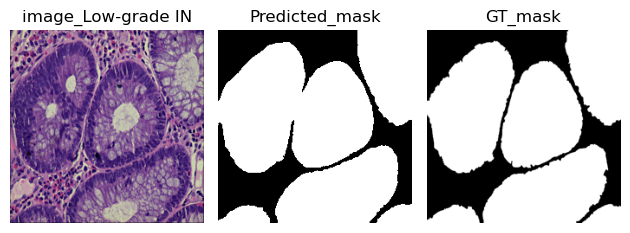

(1, 224, 224, 3)
1/1 [==============================] - 0s 50ms/step


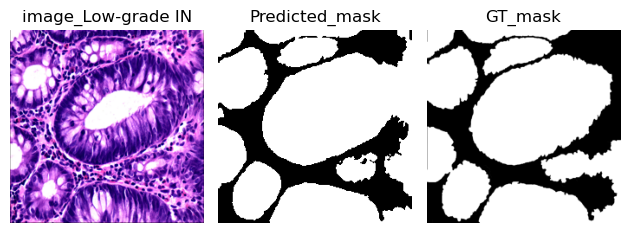

(1, 224, 224, 3)
1/1 [==============================] - 0s 46ms/step


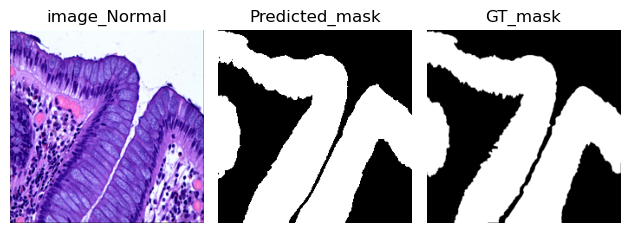

(1, 224, 224, 3)
1/1 [==============================] - 0s 60ms/step


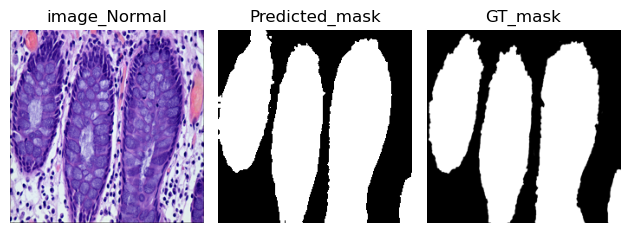

(1, 224, 224, 3)
1/1 [==============================] - 0s 50ms/step


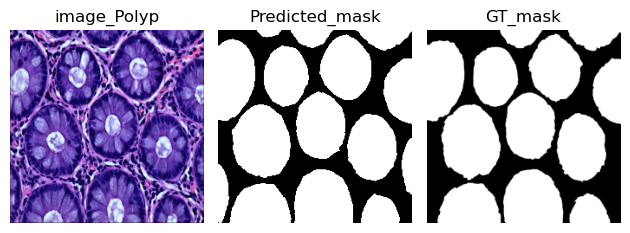

(1, 224, 224, 3)
1/1 [==============================] - 0s 57ms/step


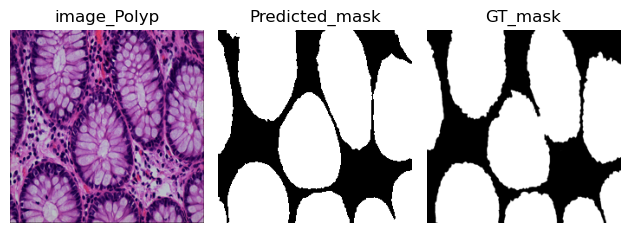

(1, 224, 224, 3)
1/1 [==============================] - 0s 69ms/step


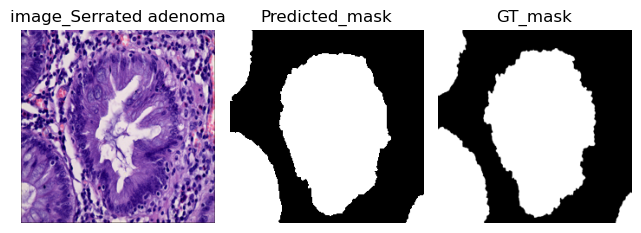

(1, 224, 224, 3)
1/1 [==============================] - 0s 56ms/step


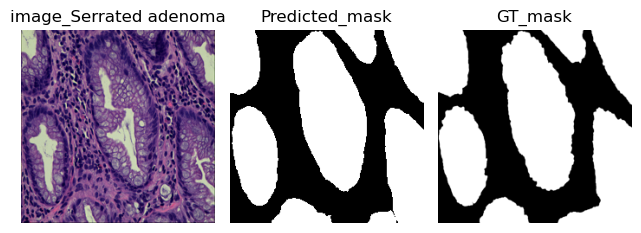

In [5]:

model.load_weights('D:/side_project/kid_project/mobile_vit_only_unet_dice.h5')
b='MobileVit-Unet+dice' 

def visualization_pred(img_path,mask_path,key):
   
    for i in range(2):#predict only two images from each regions this range can be increased as per need
        bgr_image=cv2.imread(img_path[i])
        rgb_image=cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        rgb_image=cv2.resize(rgb_image,(224,224))
        mask=cv2.imread(mask_path[i])
        mask=cv2.resize(mask,(224,224))
        mask=cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      
        
        image=np.expand_dims(rgb_image/255,axis=0)
        print(image.shape)
        prd_mask=model.predict(image)
        pr_mask=prd_mask.squeeze()
        threshold = 0.5
        pr_mask= pr_mask > threshold
        path='D:/side_project/kid_project/predictions/'+b
        os.makedirs(path,exist_ok=True)
        cv2.imwrite(path+'/'+str(key)+b+'_'+str(i)+'.jpg',pr_mask*255)
     
        fig,axes=plt.subplots(1,3)
        axes[0].imshow(rgb_image)
        axes[0].set_title("image_"+key)
        axes[1].imshow(pr_mask*255,cmap='gray')
        axes[1].set_title('Predicted_mask')
        axes[2].imshow(mask,cmap='gray')
        axes[2].set_title('GT_mask')

        # Hide axis for all subplots
        for ax in axes:
            ax.axis('off')

        # Adjust layout to prevent overlap of titles
        plt.tight_layout()

        # Show the plot
        plt.show()

key=["Adenocarcinoma","High-grade IN","Low-grade IN","Normal","Polyp","Serrated adenoma"]
for i in key:
    test_images_paths=np.load(i+"_test_images.npy",allow_pickle=False)
    test_mask_paths=np.load(i+"_test_mask.npy",allow_pickle=False)
    
    visualization_pred(test_images_paths,test_mask_paths,i)